In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import random

# importing sklearn libraries
from sklearn import neural_network, linear_model, preprocessing, svm, tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB

# importing keras libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import warnings

# supressing the warning on the usage of Linear Regression model
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
%matplotlib inline

In [3]:
forest_fires = pd.read_csv("https://firms.modaps.eosdis.nasa.gov/data/active_fire/c6/csv/MODIS_C6_Global_24h.csv")
forest_fires.head(10)

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,confidence,version,bright_t31,frp,daynight
0,-36.046,141.983,304.4,1.1,1.0,2020-10-01,45,T,51,6.0NRT,291.0,4.0,D
1,-36.582,140.812,312.7,1.0,1.0,2020-10-01,45,T,73,6.0NRT,287.5,11.6,D
2,-38.095,145.166,301.8,1.5,1.2,2020-10-01,45,T,26,6.0NRT,287.7,5.2,D
3,-17.964,-49.077,308.2,3.5,1.8,2020-10-01,120,T,72,6.0NRT,291.7,48.8,N
4,-17.948,-49.079,306.3,3.5,1.8,2020-10-01,120,T,47,6.0NRT,291.8,39.8,N
5,-17.434,-46.025,307.9,2.0,1.4,2020-10-01,120,T,73,6.0NRT,291.9,21.7,N
6,-17.436,-46.044,314.3,2.0,1.4,2020-10-01,120,T,89,6.0NRT,292.7,35.2,N
7,-17.497,-47.723,306.4,2.8,1.6,2020-10-01,120,T,68,6.0NRT,291.3,30.1,N
8,-17.491,-47.704,302.2,2.7,1.6,2020-10-01,120,T,47,6.0NRT,291.3,19.2,N
9,-17.494,-47.730,302.7,2.8,1.6,2020-10-01,120,T,51,6.0NRT,290.8,20.7,N


In [4]:
forest_fires.daynight.replace(('D','N'),(1,2), inplace=True)
#forest_fires.version.replace(('6.0NRT'),(1), inplace=True)
forest_fires.satellite.replace(('T','A'),(1,2), inplace=True)
forest_fires = forest_fires.drop(labels=["version","acq_date","acq_time"],axis="columns") 

In [5]:
forest_fires

,latitude,longitude,brightness,scan,track,satellite,confidence,bright_t31,frp,daynight
0,-36.046,141.983,304.4,1.1,1.0,1,51,291.0,4.0,1
1,-36.582,140.812,312.7,1.0,1.0,1,73,287.5,11.6,1
2,-38.095,145.166,301.8,1.5,1.2,1,26,287.7,5.2,1
3,-17.964,-49.077,308.2,3.5,1.8,1,72,291.7,48.8,2
4,-17.948,-49.079,306.3,3.5,1.8,1,47,291.8,39.8,2
...,...,...,...,...,...,...,...,...,...,...
38915,42.713,24.166,301.2,1.0,1.0,1,38,282.6,7.5,2
38916,48.169,30.619,312.2,2.2,1.4,1,84,282.9,44.1,2
38917,48.167,30.613,314.5,2.2,1.4,1,89,283.0,49.2,2
38918,60.137,16.187,302.2,1.0,1.0,1,47,280.8,7.9,2


In [6]:
forest_fires.describe()

,latitude,longitude,brightness,scan,track,satellite,confidence,bright_t31,frp,daynight
count,38920.000000,38920.000000,38920.000000,38920.000000,38920.000000,38920.000000,38920.000000,38920.000000,38920.000000,38920.000000
mean,-11.044050,-26.111318,332.239830,1.708538,1.245126,1.618114,71.555781,303.801210,66.110357,1.222251
std,19.274857,54.381093,20.483276,0.824969,0.252784,0.485855,21.897733,9.061948,142.328840,0.415764
min,-50.712000,-156.665000,300.000000,1.000000,1.000000,1.000000,0.000000,265.100000,0.000000,1.000000
25%,-23.227000,-59.189000,319.400000,1.100000,1.000000,1.000000,58.000000,297.400000,14.500000,1.000000
50%,-16.305500,-51.401500,329.000000,1.400000,1.200000,2.000000,74.000000,304.600000,28.700000,1.000000
75%,-9.795000,24.574500,339.500000,2.100000,1.400000,2.000000,89.000000,310.300000,62.200000,1.000000
max,71.254000,178.956000,506.000000,4.800000,2.000000,2.000000,100.000000,400.100000,4479.700000,2.000000


#### If fire area > 0, set the value to 1 and change column name from area to label so that we can see it as a classification problem

In [7]:
forest_fires['confidence'].values[forest_fires['confidence'].values <50] = 0
forest_fires['confidence'].values[forest_fires['confidence'].values >=50 ] = 1

forest_fires = forest_fires.rename(columns={'confidence': 'label'})
forest_fires

,latitude,longitude,brightness,scan,track,satellite,label,bright_t31,frp,daynight
0,-36.046,141.983,304.4,1.1,1.0,1,1,291.0,4.0,1
1,-36.582,140.812,312.7,1.0,1.0,1,1,287.5,11.6,1
2,-38.095,145.166,301.8,1.5,1.2,1,0,287.7,5.2,1
3,-17.964,-49.077,308.2,3.5,1.8,1,1,291.7,48.8,2
4,-17.948,-49.079,306.3,3.5,1.8,1,0,291.8,39.8,2
...,...,...,...,...,...,...,...,...,...,...
38915,42.713,24.166,301.2,1.0,1.0,1,0,282.6,7.5,2
38916,48.169,30.619,312.2,2.2,1.4,1,1,282.9,44.1,2
38917,48.167,30.613,314.5,2.2,1.4,1,1,283.0,49.2,2
38918,60.137,16.187,302.2,1.0,1.0,1,0,280.8,7.9,2


In [8]:
forest_fires.corr()

,latitude,longitude,brightness,scan,track,satellite,label,bright_t31,frp,daynight
latitude,1.000000,0.090413,-0.201655,-0.065589,-0.073158,-0.081868,-0.047789,-0.366090,-0.087753,-0.002799
longitude,0.090413,1.000000,-0.061019,-0.093357,-0.105431,0.047622,-0.023935,0.039660,-0.112521,-0.183457
brightness,-0.201655,-0.061019,1.000000,-0.053381,-0.041481,0.192692,0.270712,0.629768,0.695796,-0.400132
scan,-0.065589,-0.093357,-0.053381,1.000000,0.982818,0.032623,-0.034343,-0.115692,0.237312,-0.056818
track,-0.073158,-0.105431,-0.041481,0.982818,1.000000,0.033684,-0.030499,-0.105443,0.243192,-0.074869
satellite,-0.081868,0.047622,0.192692,0.032623,0.033684,1.000000,0.035044,0.205352,0.098081,-0.262372
label,-0.047789,-0.023935,0.270712,-0.034343,-0.030499,0.035044,1.000000,0.152840,0.134208,-0.028379
bright_t31,-0.366090,0.039660,0.629768,-0.115692,-0.105443,0.205352,0.152840,1.000000,0.252116,-0.535236
frp,-0.087753,-0.112521,0.695796,0.237312,0.243192,0.098081,0.134208,0.252116,1.000000,-0.120072
daynight,-0.002799,-0.183457,-0.400132,-0.056818,-0.074869,-0.262372,-0.028379,-0.535236,-0.120072,1.000000


### We can find the third highest correlation coefficients would be "brightness", "bright_t31", "frp"

In [10]:
forest_fires.corr()['label'].sort_values(ascending=False)

label         1.000000
brightness    0.270712
bright_t31    0.152840
frp           0.134208
satellite     0.035044
longitude    -0.023935
daynight     -0.028379
track        -0.030499
scan         -0.034343
latitude     -0.047789
Name: label, dtype: float64

# Machine Learning

### Logistic Regression Classification

In [15]:
# Logistic Regression Classification
import pandas as pd
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

scaler.fit(forest_fires.drop('label',axis=1))

scaled_features = scaler.transform(forest_fires.drop('label',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=forest_fires.columns[:-1])
df_feat.head()

X = df_feat
y = forest_fires['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=101)

logmodel = LogisticRegression(solver='liblinear')
logmodel.fit(X_train,y_train)

predictions = logmodel.predict(X_test)

from sklearn import metrics
logmodel.score(X_train,y_train)
print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))

#使用混淆矩陣
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

Accuracy: 0.8410414525522439
Precision: 0.8487912087912088
Recall: 0.9861096925748136
[[ 165 1720]
 [ 136 9655]]
              precision    recall  f1-score   support

           0       0.55      0.09      0.15      1885
           1       0.85      0.99      0.91      9791

    accuracy                           0.84     11676
   macro avg       0.70      0.54      0.53     11676
weighted avg       0.80      0.84      0.79     11676



In [16]:
classes={0:'safe',1:'On Fire'}
#x_new=[[-17.964, -49.077, 308.2 ,3.5 ,1.8, 1,291.7, 48.8, 2]]
x_new=[[-17.948, -49.079, 306.3 ,3.5 ,1.8, 1,291.8, 39.8, 2]]
y_predict=logmodel.predict(x_new)
print(classes[y_predict[0]])

On Fire


# K-Nearest

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(forest_fires.drop('label',axis=1))
scaled_features = scaler.transform(forest_fires.drop('label',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=forest_fires.columns[:-1])
df_feat.head()

,latitude,longitude,brightness,scan,track,satellite,label,bright_t31,frp
0,-1.297144,3.091083,-1.359167,-0.737659,-0.969717,-1.272235,-1.412651,-0.436392,-0.534567
1,-1.324953,3.069550,-0.953953,-0.858878,-0.969717,-1.272235,-1.798887,-0.382994,-0.534567
2,-1.403450,3.149615,-1.486101,-0.252786,-0.178518,-1.272235,-1.776816,-0.427961,-0.534567
3,-0.359019,-0.422315,-1.173647,2.171579,2.195080,-1.272235,-1.335404,-0.121624,1.870674
4,-0.358189,-0.422352,-1.266407,2.171579,2.195080,-1.272235,-1.324369,-0.184858,1.870674


In [18]:
from sklearn.model_selection import train_test_split
X = df_feat
y = forest_fires['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=101)

In [19]:
from sklearn.neighbors import KNeighborsClassifier
#從k值=1開始測試
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)

Text(0, 0.5, 'Error Rate')

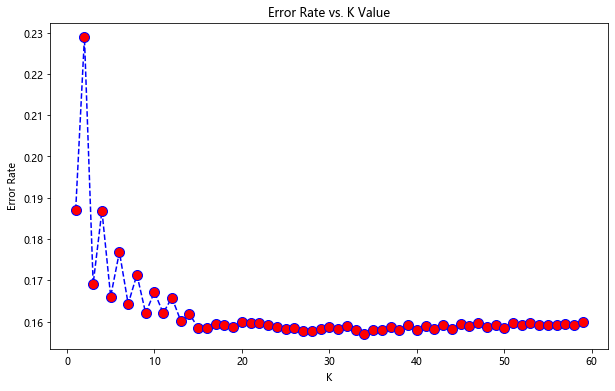

In [20]:
error_rate = []

for i in range(1,60):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))


#將k=1~60的錯誤率製圖畫出。k=7之後，錯誤率就往上跑，
plt.figure(figsize=(10,6))
plt.plot(range(1,60),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [21]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print('WITH K=15')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=15


[[ 324 1561]
 [ 289 9502]]


              precision    recall  f1-score   support

           0       0.53      0.17      0.26      1885
           1       0.86      0.97      0.91      9791

    accuracy                           0.84     11676
   macro avg       0.69      0.57      0.59     11676
weighted avg       0.81      0.84      0.81     11676



In [22]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print('WITH K=17')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=17


[[ 301 1584]
 [ 276 9515]]


              precision    recall  f1-score   support

           0       0.52      0.16      0.24      1885
           1       0.86      0.97      0.91      9791

    accuracy                           0.84     11676
   macro avg       0.69      0.57      0.58     11676
weighted avg       0.80      0.84      0.80     11676



In [23]:
knn.score(X_test, y_test)

0.8406988694758479

In [24]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, pred))
print("Precision:",metrics.precision_score(y_test, pred))
print("Recall:",metrics.recall_score(y_test, pred))

Accuracy: 0.8406988694758479
Precision: 0.8572844400396432
Recall: 0.9718108466959453


In [25]:
classes={0:'safe',1:'On Fire'}
#x_new=[[1, 4, 9 ,1 ,91.5, 130.1, 807.1, 7.5, 21.3, 35, 2.2, 0]]
#x_new=[[-16.412, -49.149, 303.3 ,3.4 ,1.7, 1,291.6, 26.9, 2]]
x_new=[[-17.964, -49.077, 308.2 ,3.5 ,1.8, 1,291.7, 48.8, 2]]

y_predict=knn.predict(x_new)
print(classes[y_predict[0]])

On Fire


# SVM

In [37]:
# Support Vector Machine
from sklearn import metrics
from sklearn.svm import SVC
# fit a SVM model to the data

X = forest_fires.drop('label', axis=1)
y = forest_fires['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=101)

svc = SVC()
svc.fit(X_train, y_train)
# make predictions
prediction = svc.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

print("Accuracy:",metrics.accuracy_score(y_test, prediction))
print("Precision:",metrics.precision_score(y_test, prediction))
print("Recall:",metrics.recall_score(y_test, prediction))

classes={0:'safe',1:'On Fire'}
#x_new=[[1, 4, 9 ,1 ,91.5, 130.1, 807.1, 7.5, 21.3, 35, 2.2, 0]]
x_new=[[-17.964, -49.077, 308.2 ,3.5 ,1.8, 1,291.7, 48.8, 2]]
y_predict=svc.predict(x_new)
print(classes[y_predict[0]])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1885
           1       0.84      1.00      0.91      9791

    accuracy                           0.84     11676
   macro avg       0.42      0.50      0.46     11676
weighted avg       0.70      0.84      0.76     11676

[[   0 1885]
 [   0 9791]]
Accuracy: 0.8385577252483727
Precision: 0.8385577252483727
Recall: 1.0
On Fire


C:\Users\e96031413\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\e96031413\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\e96031413\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
import pickle 
pickle_out = open("svc.pkl", "wb") 
pickle.dump(svc, pickle_out) 
pickle_out.close()

# Decision Tree

In [34]:
# Decision Tree Classifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

X = forest_fires.drop('label', axis=1)
y = forest_fires['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=101)

d_tree = DecisionTreeClassifier()
d_tree.fit(X_train, y_train)

# make predictions
predicted = d_tree.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

print("Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Precision:",metrics.precision_score(y_test, predicted))
print("Recall:",metrics.recall_score(y_test, predicted))

classes={0:'safe',1:'On Fire'}
#x_new=[[1, 4, 9 ,1 ,91.5, 130.1, 807.1, 7.5, 21.3, 35, 2.2, 0]]
x_new=[[-17.964, -49.077, 308.2 ,3.5 ,1.8, 1,291.7, 48.8, 2]]
y_predict=d_tree.predict(x_new)
print(classes[y_predict[0]])

              precision    recall  f1-score   support

           0       0.42      0.44      0.43      1885
           1       0.89      0.88      0.89      9791

    accuracy                           0.81     11676
   macro avg       0.65      0.66      0.66     11676
weighted avg       0.81      0.81      0.81     11676

[[ 828 1057]
 [1160 8631]]
Accuracy: 0.8101233299075026
Precision: 0.8908959537572254
Recall: 0.8815238484322336
On Fire


In [33]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
X = forest_fires.drop('label', axis=1)
y = forest_fires['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=101)

# fit a k-nearest neighbor model to the data
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

print(knn)
# make predictions
predicted = knn.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

print("Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Precision:",metrics.precision_score(y_test, predicted))
print("Recall:",metrics.recall_score(y_test, predicted))

classes={0:'safe',1:'On Fire'}
#x_new=[[1, 4, 9 ,1 ,91.5, 130.1, 807.1, 7.5, 21.3, 35, 2.2, 0]]
x_new=[[-17.964, -49.077, 308.2 ,3.5 ,1.8, 1,291.7, 48.8, 2]]
y_predict=knn.predict(x_new)
print(classes[y_predict[0]])

KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.53      0.33      0.41      1885
           1       0.88      0.94      0.91      9791

    accuracy                           0.84     11676
   macro avg       0.70      0.64      0.66     11676
weighted avg       0.82      0.84      0.83     11676

[[ 629 1256]
 [ 564 9227]]
Accuracy: 0.8441247002398081
Precision: 0.8801869693789945
Recall: 0.9423960780308447
On Fire


In [109]:
# Gaussian Naive Bayes
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

X = forest_fires.drop('label', axis=1)
y = forest_fires['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=101)

# fit a Naive Bayes model to the data
G_NB = GaussianNB()
G_NB.fit(X_train,y_train)
print(G_NB)
# make predictions

predict = G_NB.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(y_test, predict))
print(metrics.confusion_matrix(y_test, predict))

print("Accuracy:",metrics.accuracy_score(y_test, predict))
print("Precision:",metrics.precision_score(y_test, predict))
print("Recall:",metrics.recall_score(y_test, predict))

classes={0:'safe',1:'On Fire'}
#x_new=[[1, 4, 9 ,1 ,91.5, 130.1, 807.1, 7.5, 21.3, 35, 2.2, 0]]
x_new=[[-17.964, -49.077, 308.2 ,3.5 ,1.8, 120, 1,291.7, 48.8, 2]]
y_predict=G_NB.predict(x_new)
print(classes[y_predict[0]])

GaussianNB(priors=None, var_smoothing=1e-09)
              precision    recall  f1-score   support

           0       0.25      0.54      0.35      1681
           1       0.88      0.69      0.77      8502

   micro avg       0.66      0.66      0.66     10183
   macro avg       0.57      0.61      0.56     10183
weighted avg       0.78      0.66      0.70     10183

[[ 910  771]
 [2676 5826]]
Accuracy: 0.6614946479426496
Precision: 0.8831286948613006
Recall: 0.6852505292872265
safe


In [36]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# load dataset
X = forest_fires.drop('label', axis=1)
y = forest_fires['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=101)

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression(max_iter=5000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('MLP', MLPClassifier()))
models.append(('GradientBoost',GradientBoostingClassifier()))
models.append(('AdaBoost',AdaBoostClassifier()))
models.append(('Bagging',BaggingClassifier()))
models.append(('RandomForest',RandomForestClassifier()))
models.append(('ExtraTrees',ExtraTreesClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X,y,   cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.837590 (0.019618)
KNN: 0.806166 (0.037829)
CART: 0.790570 (0.024006)
NB: 0.648099 (0.171836)
SVM: 0.836511 (0.021149)
MLP: 0.831783 (0.029207)
GradientBoost: 0.854933 (0.016000)
AdaBoost: 0.849769 (0.017001)
Bagging: 0.825925 (0.023000)
RandomForest: 0.851002 (0.015410)
ExtraTrees: 0.846120 (0.016665)
